# Introduction

In this notebook I aim was to combine my interest in basketball with my data analysis skills to make a model to predict the career length of an nba player based on their stats in their rookie season. We will use classification algorithms, treating the length of one's career (in number of seasons played) as the dependent variable.

The datasets used from nba-aba-baa-stats on kaggle are:
- Player Career Info.csv
- Player Totals.csv

We choose not to use Advanced.csv because, even though advanced statistis may be more discriptive they are much more recent and we would not have substantial data to create a machine learning model.

## Getting Familiar with the Data

We first import the necessary libraries and inspect our datasets using the .info() commands from pandas.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
player_career = pd.read_csv('Player Career Info.csv')
player_total = pd.read_csv('Player Totals.csv')

Our datasets contain the following data:

#### Player Career Info

- **player_id:** discrete numerical variable of player id
- **player:** player name
- **birth_year:** birth year of the player - the majority of entries appear to be null
- **hof:** binary categorical variable showing if player made it into the hall of fame
- **num_seasons:** discrete numerical variable of the number of seasons the player played. This is our target variable.
- **first_seas:** discrete numerical variable showing the season in which the player made their debut. This is the year the season ended.
- **last_seas:** discrete numerical variable of the last season of the player.

#### Player Totals

- **seas_id:** season id - the key for this dataframe
- **season:** discrete numerical variable of the year the season ended
- **player_id:** id of player. We can use this to combine the two dataframes later.
- **player:** player name
- **birth_year:** year player was born
- **pos:** position of player in the court. We expect there to be 5 entries (PG, SG, SF, PF, C).
- **age:** age of player in the beginning of said season
- **experience:** number of seasons the player had been in the NBA in said season, including said season.
- **lg:** the league the player played in. We are only interested in NBA but it could be interesting to draw comparisons across different leagues.
- **tm:** categorical variable of the team the player played for in that season
- **g:** number of games played that season. Should range between 0 and 82.
- **gs:** number of games player was in the starting line up.
- **mp:** minutes played
- **fg:** number of field goals scored
- **fga:** number of field goal attempts
- **fg_percent:** field goal percentage
- **x3p:** number of three pointers scored
- **x3pa:** number of three pointer attempts
- **x3p_percent:** three point percentage
- **x2p:** number of two pointers scored
- **x2pa:** number of two point attempts
- **x2p_percent:** twp pointer percentage
- **e_fg_percent:** effective field goal percentage. This is a metric which measures the field goal percentage of the player adjusting for the fact that some shots count for two points and some for three. Its aim is to measure the two pointer field goal percentage someone would have to shoot at to match the output of a player's two pointers and three pointers.
- **ft:** number of free throws scored
- **fta:** number of free throw attempts
- **ft_percent:** free throw percentage
- **orb:** number of offensive rebounds
- **drb:** number of defensive rebounds
- **trb:** total rebounds
- **ast:** number of assits. An assits occurs when a pass from a player contributes to a made field goal of a teammate.
- **stl:** number of steals
- **blk:** number of blocks
- **tov:** number of turnovers
- **pf:** number of personal fouls
- **pts:** number of points scored

**That's a lot of columns!** Before data visualization it is important to make a new dataframe with only the columns we are interested in. 

We first merge the two dataframes so we are working with a single dataframes from here on out.

Since we are trying to predict the length of a player's career based on his stats in his first year we only want rows where the experience of a player in that year is 1. We also probably do not want consider players who are currently in the NBA as we do not know how many more years these players will play. To exclude them we exclude the players whose last season is listed as 2024. We also make sure to exclude players who played in the ABA or BAA.

In [18]:
player = pd.merge(player_career, player_total)
player = player[(player.experience == 1) & (player.last_seas != 2024) & (player.lg == 'NBA')]

# Data Exploration

Upon printing the dataframe's shape and unique player id count we notice that there are only 3975 unique player id's which means some id's are repeated. However, these are not duplicate rows. Upon further inspection we realize that this occurs when a given player (thus fixed player id) plays for multiple teams in their rookie seasons.

This happens when players who go undrafted sign 10-day contracts with certain teams or they get traded between teams during the season.

We still want to include these players in our analysis and we may even want to use the number of teams a player played for as an indicator for our model. 

We first create a new variable called num_tm which refers to the number of teams the player played for in their rookie seasons. We initialize this to one for every row. This way, when we combine the rows with the same player id we can simply sum these entries. Before proceeding we remove the ***birth_year, seas_id, lg*** **(league - we excluded ABA and BAA so everyone plays in the nba),** ***hof*** **(we only know this after the player finishes their career)**, ***last_seas, experience*** **(we already used this to isolate rookies)**, and ***tm*** **(team)** columns as they won't be useful to our analysis and the **first_seas** column because it contains the same information with the season column. We also remove all columns containing percentages because when we add columns these will no longer be accurate. We will recreate these later using the totals for each category.

Lastly we reset the indices of our dataframe and prepare our data for the summation. We do that by adding commas at the end of each string variable 

In [19]:
player['num_tm'] = np.ones(len(player))
player2 = player.reset_index()
player2 = player2.drop(columns = ['experience','birth_year', 'index', 'tm', 'seas_id', 'hof', 'lg', 'first_seas', 'last_seas', 'fg_percent', 'x3p_percent', 'x2p_percent', 'e_fg_percent', 'ft_percent'])

We create a list of the player id's of the players who played in multiple teams. Then, we use **.sum()** to create a new dataframe which contains the summed entries for these players. Obviously, in doing so, we have the player's name and position multiple times and the rest of their stats are also summed. To fix this, before adding we input commas in the 'player' and 'pos' columns to split the strings later and keep the first entry using **.str.split(',').str.get(0)}**. For the numerical variables we can dividie by the corresponding entry in the ***num_tm*** column. Note that some entries return as decimals which doesn't make sense for the specific data and we decide to round the values to integers.

In [20]:
#This creates a list with the player id's of the players who played in multiple teams
y = player2.player_id.value_counts()
duplicate_players = []
for i in player2.player_id:
    if i not in duplicate_players:
        if y[i] == 2:
            duplicate_players.append(i)
        elif y[i] == 3:
            duplicate_players.append(i)
        elif y[i] == 4:
            duplicate_players.append(i)

'''
We create a copy of duplicate_players which we will use later to remove the players who played
multiple seasons from the player dataframe
'''
duplicate_players2 = duplicate_players.copy()

'''
We create a new dataframe where each row is the sum of the rows which have the same player_id
in our player2 dataframe. We will then combine the new dataframes and remove the initial instances
of these players.
'''
listt = []

#iterate through the rows of our dataframe
for i in player2.index:
    #check if row is in duplicate_players
    if player2.player_id[i] in duplicate_players:
        j = (y[player2.player_id[i]]) + i #find index range where player_id is fixed
        for k in range(i,j-1):
            #add commas in between player entries and position entries to make it easier to split later
            player2.loc[k,['player']] = player2.loc[k,['player']] + ','
            player2.loc[k,['pos']] = player2.loc[k,['pos']] + ','
        summ = player2.iloc[i:j].sum() #sum rows
        listt.append(summ.values.tolist())
        #remove the player from duplicate players (to avoud counting multiple times)
        duplicate_players.remove(player2.player_id[i])
        
        
cols = player2.columns
player_sum = pd.DataFrame(listt, columns=cols) #create new dataframe

#define functions used to clean up the dataframe we created from summing the wanted rows
def divide_column_by_num_tm(dataframe, columns_to_divide, column_divisor):
    for column in columns_to_divide:
        dataframe[column] = (dataframe[column] / dataframe[column_divisor]).round().astype(int)
    return dataframe

def split_string_and_keep_first_entry(dataframe, columns_to_split):
    for column in columns_to_split:
        dataframe[column] = dataframe[column].str.split(',').str.get(0)
    return dataframe

#clean up dataframe
columns_to_divide = player2.columns.tolist()
columns_to_divide.remove('player')
columns_to_divide.remove('pos')
columns_to_divide.remove('num_tm')
columns_to_split = ['player', 'pos']
player_cleaned = divide_column_by_num_tm(player_sum, columns_to_divide, 'num_tm')
player_cleaned = split_string_and_keep_first_entry(player_cleaned, columns_to_split)

'''
We now want to remove the rows we don't need anymore from our original player database
'''
for i in player2.index:
    if player2.player_id[i] in duplicate_players2:
        player2.drop(index=i, inplace=True)

'''
Finally, combine the new dataframes to obtain the new corrected dataframe using pd.concat().
We use .sort_values to sort the rows by player_id number.
'''
player_final = pd.concat([player2, player_cleaned])
player_final.sort_values(by=['player_id'], inplace=True, ascending=True)
player_final.reset_index(inplace=True)
player_final.drop(columns=['index'], inplace=True)

We notice that, as a result from adding the rows to clean up our dataset, entries that used to be NaN are now 0. Upon research on the columns we find out that some stats were not recorded from the beginning of the league. In fact, in 1950 when the league started, the only entries from our dataset that were recorded were:
- **player**
- **num_seasons**
- **pos**
- **age**
- **g:** note that until 1967, the games from season to season suffered immense variation from teams leaving and entering the league. As a result, we will convert this to percentage of games played which will give a more descriptive account of the situation.
- **fg**
- **fga**
- **x2p**
- **x2pa**
- **ft**
- **fta**
- **ast**
- **pf**
- **pts**
- **num_tm**

The stats we do not have are:
- **gs:** started getting recorded after 1979-1980
- **mp:** records after (and including) 1951-1952 season
- **x3p, x3pa:** records beginning in 1979-80 season (when three pointer was added in the NBA)
- **orb, drb:** records beginning in 1973-74 season
- **trb:** records beginning in 1951-52 season
- **stl, blk:** records beginning in 1973-74 season
- **tov:** records in 1977-78 season

Looking at this we decide to test two data sets. A dataset with limited statistics including all the seasons (from 1950 to 2023), and a smaller dataset only including statistics from 1980 to 2023, but which has the potential to be a lot more accurate because of the increase in statistics.

## NBA All Seasons (1950-2023)

### Preprocessing

We start with the 1950 to 2023 dataset. We are only able to use the ***pos, age, fg, fga, ft, fta, ast, pf, pts*** and ***num_tm*** stats to create our indicator variables. Notice that using ***x2p*** and ***x2pa*** would produce skewed results because, up until the addition of the three point line, the only field goal was a two pointer so we would be including **fg** and **fga** twice.

Using these variables we want to also create some new ones which will be normalized to the games played of the player. For example, two players could have scored the same number of points in a season but one player did it in half as many games. By using the raw points data we would not be able to differentiate between these. We create a new dataframe with the following data:
- **player_id, player:** we need these to identify the players
- **num_seasons:** the target variable
- **pos**
- **fg, fga**
- **fgp:** field goal percentage: field goals divided by field goal attempts
- **ft, fta**
- **ftp:** free throw percentage: free throws divided by free throw attempts
- **apg:** assists per game
- **pfpr:** personal fouls per game
- **ppg:** points per game
- **num_tm**


In [21]:
cols = ['player_id', 'player', 'num_seasons', 'pos', 'fg', 'fga', 'ft', 'fta', 'ast', 'pf', 'pts', 'g']
player_1950to2023 = pd.DataFrame(player_final, columns=cols)
player_1950to2023['fgp'] = player_1950to2023.fg / player_1950to2023.fga
player_1950to2023['ftp'] = player_1950to2023.ft / player_1950to2023.fta
player_1950to2023['apg'] = player_1950to2023.ast / player_1950to2023.g
player_1950to2023['pfpg'] = player_1950to2023.pf / player_1950to2023.g
player_1950to2023['ppg'] = player_1950to2023.pts / player_1950to2023.g
player_1950to2023.pos = player_1950to2023.pos.str.split('-').str.get(0) #get player's primary position
ohe = pd.get_dummies(player_1950to2023.pos)
player_1950to2023 = player_1950to2023.join(ohe)
player_1950to2023.drop(columns=['pos'], inplace=True)
player_1950to2023.dropna(inplace=True)
player_1950to2023['num_seasons'] = player_1950to2023['num_seasons'].astype(float)

We now use Filter methods to determine if we should use all of the indicators in our dataframe. The following heatmap is a correlation matrix between the independent variables and the dependent variable in our dataframe.

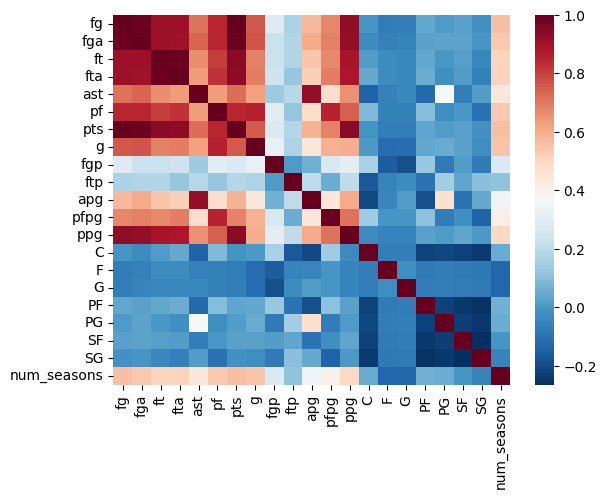

In [22]:
#define the independent variables x and the dependent variable y
num_cols = len(player_1950to2023.columns)

x = player_1950to2023.iloc[:,3:num_cols]
y = player_1950to2023.iloc[:,2:3]
z = x.join(y)

# from scipy.stats import pearsonr
# corr, pval = pearsonr(df2['VOL'], df2['MPG'])
# print(coor)

corr_matrix = z.corr()
sns.heatmap(corr_matrix, annot=False, cmap='RdBu_r')
plt.show()

There is no single variable with very high correlation with our target variable, ***num_season***. However, we observe that there are variables which are highly correlated with each other. Namely,
- **fg, fga, pts** and **ppg**: perhaps not surpising but we should only include one of the four. We decide on **ppg** because in a way it encapsulates the other three
- **ft** and **fta**: again, not surprising. We decide to use **fta** because we can see it affects the num_seasons more.

In [23]:
player_1950to2023.drop(columns=['fg','fga','pts','ft'],inplace=True)

### Data Analysis: NBA All Seasons (1950-2023)

We split our data to an 80:20 test train split and use random state 23 for reproducibility. We import the necessary libraries and perform MultiLinear Regression and Decision Tree Regression.

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.8, random_state=23)

y_train = y_train.num_seasons.to_numpy()
y_test = y_test.num_seasons.to_numpy()

#multilinear regression
mlr = LinearRegression().fit(x_train,y_train)
print('Score of MultiLinear Regression: ' + str(mlr.score(x_test,y_test)))

#decision tree regression
param_grid = {
    'max_depth': np.arange(1,10),
    'min_samples_split': np.arange(2,20)
}

dt = DecisionTreeRegressor()

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='r2', return_train_score=True)
grid_search.fit(x_train, y_train)

print(f'The best parameters for a Decision Tree Regression model are {grid_search.best_params_} which produce a training score of {grid_search.best_score_}.')
print(f'Score of Decision Tree Regression {grid_search.score(x_test, y_test)}')

Score of MultiLinear Regression: 0.38995882007191895
The best parameters for a Decision Tree Regression model are {'max_depth': 4, 'min_samples_split': 2} which produce a training score of 0.3173194119623048.
Score of Decision Tree Regression 0.3556703664201316


c:\Users\oikoh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


The score of the Multilinear Regression model is 0.39 and that of the Decision Tree Regression is 0.35 which is relatively low. We probably could use classifiers instead of regression to achieve higher accuracy (treating career length as discrete classification categories). Instead, let's try to analyze the dataset from 1980 to 2023 where we have more data to see if we can fit a better model there.

## NBA Seasons 1980-2023

### Preprocessing

Here we keep all of the original columns and we also add:
- **pos:** we again need to hot-encode this as it is a categorical variable
- **pgs:** percentage of games in which the player started
- **pgp:** games played / total games in the season. Most season are 82 games long. However, we need to keep in mind that since the 1980 season there have been three lockouts which have shortened some seasons.
 - 1999 season was 50 games long due to delas in when it started
 - 2012 season was 66 games long due to lockout
 - 2020 season was 69 games long due to covid lockdown (teams at that point had played 63-75 games so we take 69 as the average length per team)
 - 2021 season was 72 games long due to start delay because of Covid-19 quarantine
- **mpg:** minutes per game
- **fgp:** field goals divided by field goal attempts
- **3pp:** three point field goals divided by three point attempts
- **2pp:** two point field goals divided by two point attempts
- **ftp:** free throws divided by free throw attempts
- **orpg, drpg** offesnive/defensive rebounds per game. In adding these we will remove **orb** and **drb** as the two would be highly correlated. These two also incorproate the total rebounds so we will remove the total rebounds from our dataframe.
- **apg:** assists per game
- **spg:** steals per game
- **bpg:** blocks per game
- **tpg:** turnovers per game
- **pfpg:** personal fouls per game
- **ppg:** points per game

In calculating all the per-game stats we will automatically remove the totals for these categories, because otherwise we will have two many features and they won't fit into the correlation matrix. We can expect, for example, assists and assists per game to be highly correlated and so this should not take away from the power of the model later on.

In [25]:
player_1980to2023 = pd.DataFrame(player_final[player_final['season'] >= 1980])
player_1980to2023.dropna(inplace=True)
ohe2 = pd.get_dummies(player_1980to2023.pos)
player_1980to2023 = player_1980to2023.join(ohe)
player_1980to2023.drop(columns=['pos'], inplace=True)
player_1980to2023['pgs'] = player_1980to2023.gs / player_1980to2023.g
player_1980to2023['num_games_in_season'] = 82
for i in player_1980to2023.index:
    if player_1980to2023['season'][i] == 1999:
        player_1980to2023.loc[i,['num_of_seasons']] = 50
    elif player_1980to2023['season'][i] == 2012:
        player_1980to2023.loc[i,['num_of_seasons']] = 66
    elif player_1980to2023['season'][i] == 2020:
        player_1980to2023.loc[i,['num_of_seasons']] = 69
    elif player_1980to2023['season'][i] == 2021:
        player_1980to2023.loc[i,['num_of_seasons']] = 72
    else:
        player_1980to2023.loc[i,['num_of_seasons']] = 82
player_1980to2023['pgp'] = player_1980to2023.g / player_1980to2023.num_games_in_season
player_1980to2023['mpg'] = player_1980to2023.mp / player_1980to2023.g
player_1980to2023['fgp'] = player_1980to2023.fg / player_1980to2023.fga
player_1980to2023['3pp'] = player_1980to2023.x3p / player_1980to2023.x3pa
player_1980to2023['2pp'] = player_1980to2023.x2p / player_1980to2023.x2pa
player_1980to2023['ftp'] = player_1980to2023.ft / player_1980to2023.fta
player_1980to2023['orpg'] = player_1980to2023.orb / player_1980to2023.g
player_1980to2023['drpg'] = player_1980to2023.drb / player_1980to2023.g
player_1980to2023['apg'] = player_1980to2023.ast / player_1980to2023.g
player_1980to2023['bpg'] = player_1980to2023.blk / player_1980to2023.g
player_1980to2023['spg'] = player_1980to2023.stl / player_1980to2023.g
player_1980to2023['pfpg'] = player_1980to2023.pf / player_1980to2023.g
player_1980to2023['tpg'] = player_1980to2023.tov / player_1980to2023.g
player_1980to2023['ppg'] = player_1980to2023.pts / player_1980to2023.g

player_1980to2023.drop(columns=['g', 'gs', 'mp', 'fg', 'fga', 'x3p', 'x3pa', 'x2p', 'x2pa','ft','fta','orb',
                               'drb', 'trb', 'ast','stl','blk','tov','pf','pts'], inplace=True)

The following heatmap is a correlation matrix for the features in our new dataframe. Most features are not highly correlated, which is good. The only decently correlation is between **two point percentage** and **field goal percentage** so we decide to only keep **field goal percentage**.

Using **.info()** we realize that even though we removed all null values to calculations, there are still null values in the shooting percentages of the players. These are likely cause by division with zero. We can replace these values by zero as intuitevly, shooting 0 for 0 is shooting 0 percent.

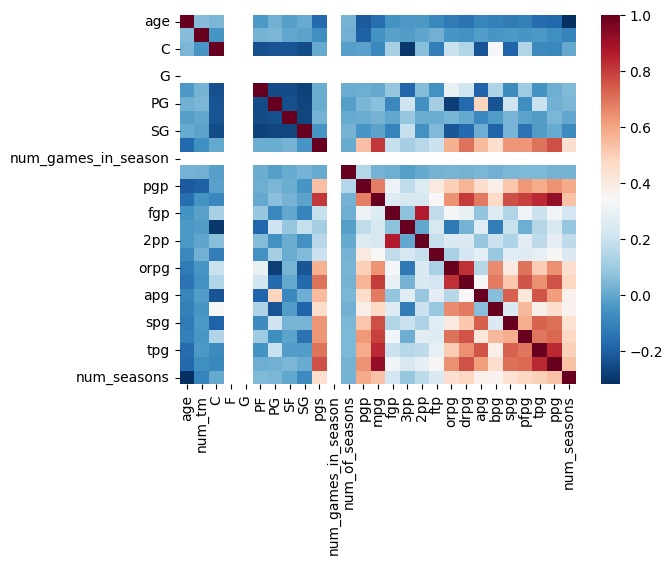

In [26]:
player_1980to2023.fillna(value={'fgp':0, '3pp':0, '2pp':0, 'ftp':0}, inplace=True) #fill NaN by zero

num_cols2 = len(player_1980to2023.columns)
x2 = player_1980to2023.iloc[:,4:num_cols2]
y2 = player_1980to2023.iloc[:,2:3]
z2 = x2.join(y2)

corr_matrix = z2.corr()
sns.heatmap(corr_matrix, annot=False, cmap='RdBu_r')
plt.show()

player_1980to2023.drop(columns=['2pp'], inplace=True)

### Data Analysis: NBA Seasons 1980-2023

We again decide on an 80:20 train test split. We split the data and use the already imported LinearRegression module to perform multilinear regression and we also test the DecisionTreeRegressor using GridSearch for hyperparameter optimization

In [27]:
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, train_size=.8, random_state=45)

y2_train = y2_train.num_seasons.to_numpy()
y2_test = y2_test.num_seasons.to_numpy()

mlr2 = LinearRegression().fit(x2_train, y2_train)
print('Multilinear Rregression Score: ' + str(mlr2.score(x2_test, y2_test)))

Multilinear Rregression Score: 0.4702748008750631


The score of this model is improved by still not satisfactory at 0.47. However, it seems this is as far as we will get with Linear Regression.

In [29]:
param_grid = {
    'max_depth': np.arange(1,10),
    'min_samples_split': np.arange(2,20)
}

dt2 = DecisionTreeRegressor()

grid_search2 = GridSearchCV(dt2, param_grid, cv=5, scoring='r2', return_train_score=True)
grid_search2.fit(x2_train, y2_train)

print(f'The best parameters for a Decision Tree Regression model are {grid_search2.best_params_} which produce a training score of {grid_search2.best_score_}.')
print(f'Score of Decision Tree Regression {grid_search2.score(x2_test, y2_test)}')

The best parameters for a Decision Tree Regression model are {'max_depth': 4, 'min_samples_split': 3} which produce a training score of 0.3435460266888567.
Score of Decision Tree Regression 0.40196368536505944


c:\Users\oikoh\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Using a Decision Tree Classifier model gives a score of 0.4, which is worse than that of the Multilinear Regression model leading us to conclude that more complex models will perform worse due to the limited amount of data available (since complex models are more prone to overfitting)

# Conclusion and Model Evaluation

We used 2 different data sets to try and predict the career length of an nba player. The first was a larger dataset which used fewer independent variables for its prediction and the second was a more complex model. For the latter, however, less data was overall available presenting a risk of the data not being enough to train a sophisticated model.

For both datasets we first tried Multilinear Regression. In the first dataset we got a score of 0.39 meaning the model was able to predict 39% of the variation in the dataset, while in the second dataset, our Multilinear Regression model was able to predict 47% percent of the variation in the dataset.

We also performed Decision Tree Regression for both datasets, using GridSearch for hyperparameter optimization but it consistenly performed worse than the simple Multilinear Regression.

Overall, the second model was more accurate but a score of 0.47 is by no means satisfactory to make accruate predictions for the careers of current players. While some more statistics could have been used in this model (first-team rookie votes, second-team rookie votes, and perhaps even more complex statistics such as the seed of a team in the year before the signing of each player) the accuracy is not likely to increase significantly. Experts in the field (recruitment coaches, sports analysts) are likely to make more accurate predictions on a case by case bases.

Reflecting again on the correlation matrix of the various parameters we used vs the length of each player's career we see that the main downfall of the model is not the limited size of the dataset (although that definitely plays a role) but rather that statistics alone don't tell the whole picture.

This makes sense, as a rookie player who performs well in a rebuilding team might be less valuable in the long-run than a rookie who has a very specific role in a top team and performs his role excellently in limited minutes (and thus overall reduced statistics) in that team, leading the former to have a smaller career.

**I learned a lot about ML and data processing in this exploration! Please let me know if you discover some oversights etc in this notebook. All criticism is welcome!**